# <font color=yellow>Transfer Learning</font> for Font-type Recognition with [Keras](https://keras.io/)</font>

<img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" alt="Keras logo" height="100" width="250"> 

---

# * [MSTC](http://mstc.ssr.upm.es/big-data-track) and MUIT: <font size=5 color='green'>Deep Learning</font>

* <font size=5 color='green'>Machine Learning Lab (MLLB)</font>
 
---
---


In [1]:
import keras

from keras.utils import to_categorical

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

      
print('Keras version: ',keras.__version__)

Keras version:  2.4.3


## <font color= #00cc00>Next cells load the Font Type dataset:</font>


In [2]:
"""
Load and data
"""

import os
from six.moves import urllib

file_url = 'https://github.com/bloolizard/PlayWithTensorFlow/raw/master/data_with_labels.npz'
file_name = 'data_with_labels.npz'

if not os.path.exists(file_name):
    urllib.request.urlretrieve(file_url, file_name)
    
    
# Load data
data = np.load('data_with_labels.npz')

images = data['arr_0']/255.
labels = data['arr_1']

onehot= to_categorical(labels, num_classes=len(np.unique(labels)))

## Preparing Train/Test Data :
- ### Random Permutation! + split data into training / validation

In [3]:
# Split data into training (90%) and validation (10%)
np.random.seed(100)

indices = np.random.permutation(images.shape[0])

valid_cnt = int(images.shape[0] * 0.1)

test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
  
test_ori, train_ori = images[test_idx,:],\
              images[training_idx,:]
  
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]


In [4]:
train_ori=train_ori.reshape([-1,train_ori.shape[1],train_ori.shape[2]])
test_ori=test_ori.reshape([-1,test_ori.shape[1],test_ori.shape[2]])

print('Train images ORIGINAL shape=', train_ori.shape , '\nTest images ORIGINAL shape=', test_ori.shape)

Train images ORIGINAL shape= (2511, 36, 36) 
Test images ORIGINAL shape= (279, 36, 36)


#Resize your images to have: 3 channels (RGB) and same dimensions as the Pre-trained network you are going to use
  
  

In [5]:
from skimage.transform import resize
from skimage.color import gray2rgb 

# 224 x 224 for VGG
hori=224
vert=224

train = np.zeros((train_ori.shape[0],hori,vert,3))
test = np.zeros((test_ori.shape[0],hori,vert,3))

for n,i in enumerate(train_ori):
    new_img = gray2rgb(train_ori[n,:,:])
    train[n,:,:,:] = resize(new_img, train.shape[1:], anti_aliasing=True)
    
    

for n,i in enumerate(test_ori):
    new_img = gray2rgb(test_ori[n,:,:])
    test[n,:,:,:] = resize(new_img, test.shape[1:], anti_aliasing=True)
    
    

In [6]:
print('Train images shape=', train.shape , '\nTest images shape=', test.shape)

Train images shape= (2511, 224, 224, 3) 
Test images shape= (279, 224, 224, 3)


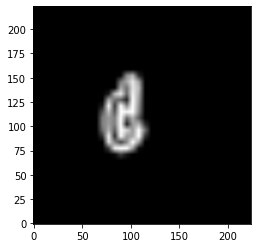

In [7]:
plt.imshow(train[2000,:,:,:], origin='lower')

---
<font size=6 color=yellow>BUILD the "transfer learning" Model:</font><br>
- <font size=4 > We can try with many pre-trained Models:</font><br><br>
-- <font size=4>We will try a simple Model</font><font size=4 color='orange'> **VGG16**</font><br>
-- <font size=4> ...but there are many : </font> **Xception, InceptionV3, or ResNet50**

---

In [8]:
from keras import applications

# In this way input tensor shape is forced
# to be (224, 224, 3)

#vgg_model = applications.VGG16(weights='imagenet', include_top=True)


################## Change the VGG model ###################################################################
#vgg_model = applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=(299, 299, 3), pooling=None, classes=1000)
#vgg_model = applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=(299, 299, 3), pooling=None, classes=1000)
resnet_model = applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling=None, classes=1000)


102973440/102967424 [==============================] - 1s 0us/step


In [9]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

- ## We can remove the last added layer in a Sequential model by calling .pop():

In [10]:
# Note that if you call it several times you remove the last after the previous 

resnet_model.layers.pop()
resnet_model.layers.pop()
resnet_model.layers.pop()


In [12]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

---
---

## <font size= 6 color=yellow>Now we use KERAS API</font>

---


## We can add some more layers (we only add one softmax):
##- `vgg_model.layers[-1].output` is the last output of VGG16 (after pop-ing out the last layers)


In [17]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Model


x = Dropout(rate=0.4)(resnet_model.layers[-1].output)
x = Dense(64, activation='relu')(x)  # new softmax layer
predictions = Dense(5, activation='softmax', name='softmax_new1')(x)  # new softmax layer
transfer_model = Model(inputs=resnet_model.input, outputs=predictions)

In [18]:
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# We can <font color=red>Freeze</font> Layers <font color=green> ... or NOT</font>

In [ ]:
# Make sure that the pre-trained bottom layers are not trainable

for layer in vgg_model.layers:
        layer.trainable = False

In [20]:
from keras.layers import BatchNormalization
for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# COMPILE... as usual

In [21]:
import keras


transfer_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])

## You can check which layers are trainable...

In [22]:
for i in range(1, len(transfer_model.layers)):
    print('Layer: ' , i, 'Trainable: ', transfer_model.layers[i].trainable)


Layer:  1 Trainable:  False
Layer:  2 Trainable:  False
Layer:  3 Trainable:  True
Layer:  4 Trainable:  False
Layer:  5 Trainable:  False
Layer:  6 Trainable:  False
Layer:  7 Trainable:  False
Layer:  8 Trainable:  True
Layer:  9 Trainable:  False
Layer:  10 Trainable:  False
Layer:  11 Trainable:  True
Layer:  12 Trainable:  False
Layer:  13 Trainable:  False
Layer:  14 Trainable:  False
Layer:  15 Trainable:  True
Layer:  16 Trainable:  True
Layer:  17 Trainable:  False
Layer:  18 Trainable:  False
Layer:  19 Trainable:  False
Layer:  20 Trainable:  True
Layer:  21 Trainable:  False
Layer:  22 Trainable:  False
Layer:  23 Trainable:  True
Layer:  24 Trainable:  False
Layer:  25 Trainable:  False
Layer:  26 Trainable:  True
Layer:  27 Trainable:  False
Layer:  28 Trainable:  False
Layer:  29 Trainable:  False
Layer:  30 Trainable:  True
Layer:  31 Trainable:  False
Layer:  32 Trainable:  False
Layer:  33 Trainable:  True
Layer:  34 Trainable:  False
Layer:  35 Trainable:  False
Laye

In [ ]:
transfer_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# TRAIN...

# 3.   **Fit your model**. Train the model using data.

In [ ]:
# history to analyze training history evolution

# validation_data allows to see evaluation on test while training
history=transfer_model.fit(train, onehot_train,
         epochs=50,
         batch_size=128,
         validation_data=(test, onehot_test),
         verbose=1)

Epoch 1/50


## 4.   **Make predictions**. Use the model to generate predictions on new data.

In [ ]:
# Check accuracy on train set

loss_train, accuracy_train = transfer_model.evaluate(train, onehot_train, batch_size=128)


print('\nTraining Accuracy=', accuracy_train)

# Check accuracy on test set

loss, accuracy = transfer_model.evaluate(test, onehot_test, batch_size=128)


print('\nTest Accuracy=', accuracy)

2511/2511 [==============================] - 7s 3ms/step

Training Accuracy= 1.0
279/279 [==============================] - 1s 3ms/step

Test Accuracy= 1.0


In [ ]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Train Accuracy:  1.0
Test_Accuracy:  1.0


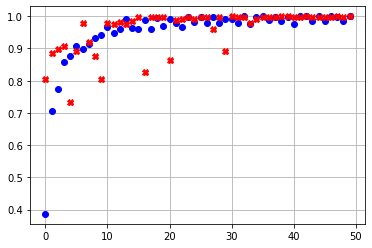

In [ ]:
print('Train Accuracy: ',np.round(history.history['acc'][-1],2))
print('Test_Accuracy: ',np.round(history.history['val_acc'][-1],2))

# Plot the accuracy curves
plt.plot(history.history['acc'],'bo')
plt.plot(history.history['val_acc'],'rX')
plt.grid()

# Get predictions / probabilities ...

In [ ]:
pred_probabilities= transfer_model.predict(test)

print('First Five Probs.:\n',pred_probabilities[0:5])

print('\n\nFirst Five Classes:\n',onehot_test[0:5])

First Five Probs.:
 [[4.19948104e-12 2.84761903e-09 4.14075496e-10 7.20562255e-14
  1.00000000e+00]
 [2.18054964e-04 9.99773920e-01 5.81434165e-07 7.43765941e-06
  2.28566908e-08]
 [6.35377201e-15 1.16945148e-10 1.04011678e-12 1.94049556e-14
  1.00000000e+00]
 [9.11509153e-03 6.24286031e-06 9.90878642e-01 1.22253105e-08
  1.63129010e-09]
 [4.23254190e-15 1.86968209e-05 2.28265585e-17 9.99981284e-01
  9.81632717e-14]]


First Five Classes:
 [[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


## Confusion Matrix

Confusion Matrix:
 [[61  0  0  0  0]
 [ 0 71  0  0  0]
 [ 0  0 48  0  0]
 [ 0  0  0 43  0]
 [ 0  0  0  0 56]]


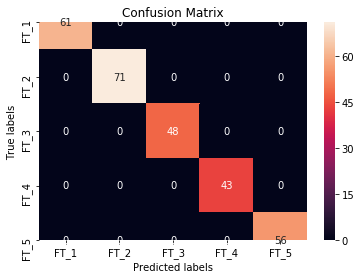

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix as cm

ConfMatrix=cm(np.argmax(onehot_test,1), np.argmax(pred_probabilities,1))

print('Confusion Matrix:\n',ConfMatrix)

ax= plt.subplot()
sns.heatmap(ConfMatrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['FT_1', 'FT_2','FT_3','FT_4','FT_5'])
ax.yaxis.set_ticklabels(['FT_1', 'FT_2','FT_3','FT_4','FT_5']);